In [1]:
import os
import numpy as np
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.transforms import functional as TVF
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split

import os

data_dir = "fruits-360-original-size"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
data_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.RandomHorizontalFlip(),  
    transforms.RandomRotation(10), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225]),
])

In [3]:
trainset = ImageFolder(data_dir + "/Training", transform=data_transform)
train_size = int(0.8 * len(trainset)) 
val_size = len(trainset) - train_size 

trainSubset, valSubset = random_split(trainset, [train_size, val_size])

train_loader = DataLoader(trainSubset, batch_size=32, shuffle=True)
val_loader = DataLoader(valSubset, batch_size=32, shuffle=False)


In [4]:
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

def train(net, trainloader, valloader, device, num_epochs, lr=0.01, momentum=0.8, step_size=5, gamma=0.1, verbose=True):
    
    loss_iterations = int(np.ceil(len(trainloader) / 3))
    
    # Transfer model to GPU
    net = net.to(device)

    # Set the optimizer using the lr and momentum settings passed by the user
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    for epoch in range(num_epochs):
        running_loss = 0
        running_corrects = 0
        total_samples = 0

        # Training phase
        net.train()  # Ensure the model is in training mode
        for i, (inputs, labels) in enumerate(trainloader):
            optimizer.zero_grad()

            # Transfer data to GPU
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward propagation to get outputs
            outputs = net(inputs)

            # Compute loss
            loss = F.cross_entropy(outputs, labels)

            # Backpropagation to get gradients of all parameters
            loss.backward()

            # Update parameters
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy for the batch
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels)
            total_samples += inputs.size(0)

        # Calculate average training loss and accuracy
        train_loss = running_loss / total_samples
        train_acc = running_corrects.double() / total_samples

        # Validation phase
        net.eval()  # Set model to evaluation mode
        val_loss = 0
        val_corrects = 0
        val_samples = 0

        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in valloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = net(inputs)
                loss = F.cross_entropy(outputs, labels)

                val_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels)
                val_samples += inputs.size(0)

        val_loss /= val_samples
        val_acc = val_corrects.double() / val_samples

        print(f'[Epoch {epoch+1:2d}]: train_loss = {train_loss:.4f}, train_acc = {train_acc:.4f}, '
              f'validation_loss = {val_loss:.4f}, validation_acc = {val_acc:.4f}')

        scheduler.step()  # Step the learning rate scheduler

    print("Training completed.")


In [5]:
def evaluate(net, dataloader, device):
    net.eval()  # Set model to evaluation mode
    running_corrects = 0
    
    with torch.no_grad():  # Disable gradient computation
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)  # Extract the predicted class indices
            running_corrects += (predicted == targets).sum().item()  # Compare indices directly

    acc = running_corrects / len(dataloader.dataset)

    print(f'Accuracy: {acc:.4f}')

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 131) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1_bn(self.conv1(x))))
        x = self.pool(F.relu(self.conv2_bn(self.conv2(x))))
        x = self.pool(F.relu(self.conv3_bn(self.conv3(x))))
        x = self.pool(F.relu(self.conv4_bn(self.conv4(x))))
        
        x = x.view(-1, 256 * 6 * 6)
        
        x = F.dropout(F.relu(self.fc1(x)), training=self.training, p=0.5)
        x = F.dropout(F.relu(self.fc2(x)), training=self.training, p=0.5)
        x = self.fc3(x)
        
        return x

In [7]:
model = NeuralNetwork()
model

NeuralNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=9216, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=131, bias=True)
)

In [23]:
train(model, train_loader, val_loader, device, num_epochs=10, lr=0.01, momentum=0.9, step_size=5, gamma=0.1)

[Epoch  1]: train_loss = 1.0892, train_acc = 0.6437, validation_loss = 0.3384, validation_acc = 0.8733
[Epoch  2]: train_loss = 0.8969, train_acc = 0.7173, validation_loss = 0.2594, validation_acc = 0.8901
[Epoch  3]: train_loss = 0.7806, train_acc = 0.7693, validation_loss = 0.2985, validation_acc = 0.9094
[Epoch  4]: train_loss = 0.6674, train_acc = 0.7982, validation_loss = 0.1195, validation_acc = 0.9759
[Epoch  5]: train_loss = 0.6309, train_acc = 0.8184, validation_loss = 0.2748, validation_acc = 0.8974
[Epoch  6]: train_loss = 0.3706, train_acc = 0.8866, validation_loss = 0.0286, validation_acc = 0.9920
[Epoch  7]: train_loss = 0.2643, train_acc = 0.9115, validation_loss = 0.0241, validation_acc = 0.9944
[Epoch  8]: train_loss = 0.2293, train_acc = 0.9224, validation_loss = 0.0217, validation_acc = 0.9936
[Epoch  9]: train_loss = 0.2139, train_acc = 0.9310, validation_loss = 0.0208, validation_acc = 0.9936
[Epoch 10]: train_loss = 0.1812, train_acc = 0.9438, validation_loss = 0.

In [26]:
test_transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],  
                         std=[0.229, 0.224, 0.225]),
])

testset = ImageFolder(data_dir + "/Test", transform=test_transform)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)
evaluate(model, test_loader, device)

Accuracy: 1.0000


In [25]:
import torch

def predict_image(img, model):
    # Ensure the model is in evaluation mode
    model.eval()
    
    # Move the model to the correct device (CPU or GPU)
    device = next(model.parameters()).device
    
    # Move the input to the same device as the model
    img = img.to(device)
    
    # Convert to a batch of 1
    xb = img.unsqueeze(0)
    
    # Get predictions from the model
    with torch.no_grad():  # Disable gradient computation
        yb = model(xb)
        
    # Pick index with highest probability
    _, preds = torch.max(yb, dim=1)
    
    return preds.item()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: zucchini_dark_1 Predicted: 18


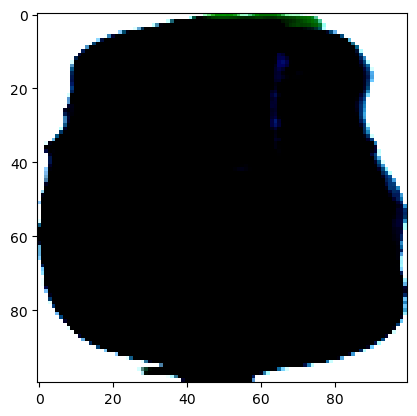

In [22]:
img, label = testset[3032]
plt.imshow(img.permute(1, 2, 0))
print('Label:', trainset.classes[label], 'Predicted:', predict_image(img, model))